In [2]:
import pandas as pd

# Load the dataset
file_path = 'C:/Users/Admin/Downloads/Global_Landslide_Catalog_Export.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(df.head())

# Get basic information about the dataset
print(df.info())

# Check for missing values
print(df.isnull().sum())


   source_name                                        source_link event_id  \
0          AGU  https://blogs.agu.org/landslideblog/2008/10/14...      684   
1    Oregonian  http://www.oregonlive.com/news/index.ssf/2009/...      956   
2     CBS News  https://www.cbsnews.com/news/dozens-missing-af...      973   
3      Reuters  https://in.reuters.com/article/idINIndia-41450...    1,067   
4  The Freeman  http://www.philstar.com/cebu-news/621414/lands...    2,603   

               event_date  event_time  \
0  08/01/2008 12:00:00 AM         NaN   
1  01/02/2009 02:00:00 AM         NaN   
2  01/19/2007 12:00:00 AM         NaN   
3  07/31/2009 12:00:00 AM         NaN   
4  10/16/2010 12:00:00 PM         NaN   

                                         event_title  \
0      Sigou Village, Loufan County, Shanxi Province   
1                                Lake Oswego, Oregon   
2  San Ramon district, 195 miles northeast of the...   
3                                   Dailekh district   
4   

In [3]:
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Handle missing values
columns_to_drop = ['event_time', 'photo_link', 'notes', 'storm_name']
df.drop(columns=columns_to_drop, inplace=True)

# Fill missing values in categorical columns with mode
categorical_columns = ['location_description', 'location_accuracy', 'landslide_category', 'landslide_trigger', 'admin_division_name']
for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Remove commas and convert to numeric for the specified columns
numerical_columns = ['fatality_count', 'injury_count', 'gazeteer_distance']
for col in numerical_columns:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)
    df[col].fillna(df[col].median(), inplace=True)

# Drop any remaining rows with missing values
df.dropna(inplace=True)

# Text cleaning function
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d', '', text)  # Remove digits
    text = re.sub(r'\n', ' ', text)  # Remove newlines
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in STOPWORDS]
    return ' '.join(words)

df['clean_text'] = df['event_description'].apply(clean_text)

# Verify cleaned text
print(df['clean_text'].head())


C:\Users\Admin\AppData\Local\Temp\ipykernel_21088\278629635.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_21088\278629635.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

0         occurred early morning villager buried house
1    hour heavy rain blame overnight mudslide lake ...
2    cbsap least people died many still missing wed...
3       one person killed dailekh district police said
4    another landslide sitio bakilid barangay lahug...
Name: clean_text, dtype: object


       fatality_count  injury_count  gazeteer_distance    longitude  \
count     8569.000000   8569.000000        8569.000000  8569.000000   
mean         3.347182      0.379157          11.474494    15.351910   
std         63.303347      5.625895          15.786612    96.930737   
min          0.000000      0.000000           0.000030  -170.799800   
25%          0.000000      0.000000           2.200520   -83.477100   
50%          0.000000      0.000000           5.743500    72.866300   
75%          1.000000      0.000000          14.820580    99.702200   
max       5000.000000    374.000000         215.448880   179.422100   

          latitude  
count  8569.000000  
mean     23.986815  
std      20.479765  
min     -46.774800  
25%      11.134500  
50%      28.053700  
75%      38.733000  
max      72.627500  
                   fatality_count  injury_count  gazeteer_distance  longitude  \
fatality_count           1.000000      0.052962           0.023436   0.027164   
injury_co

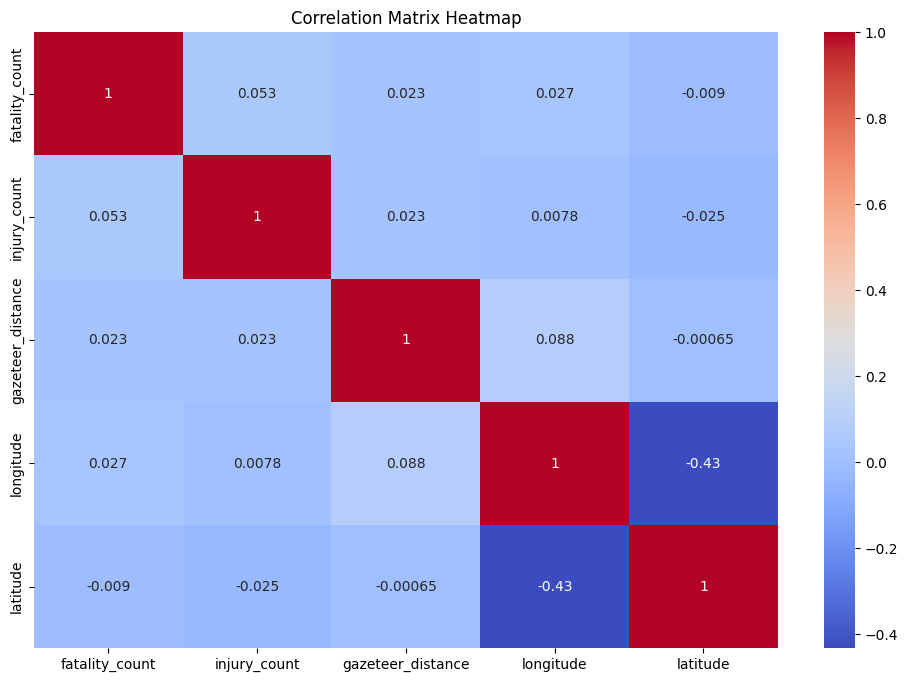

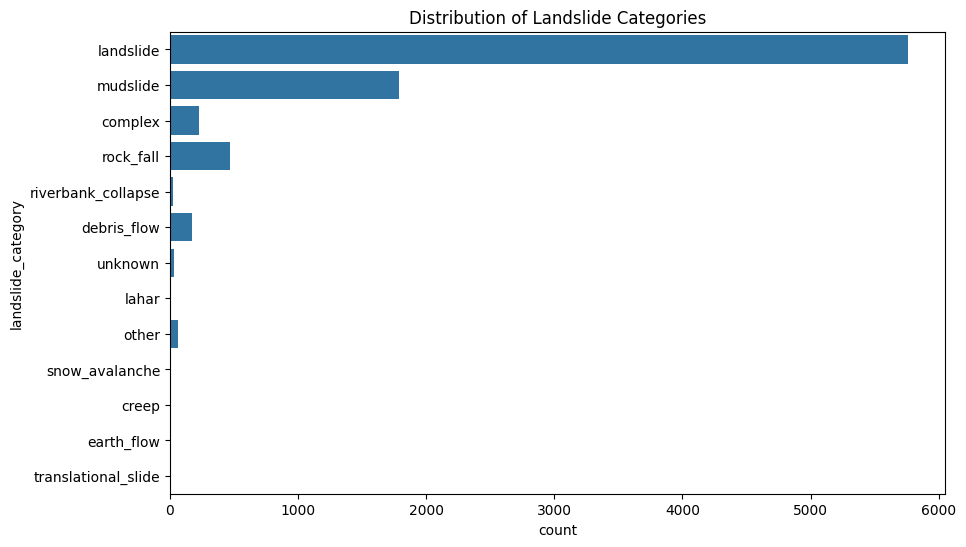

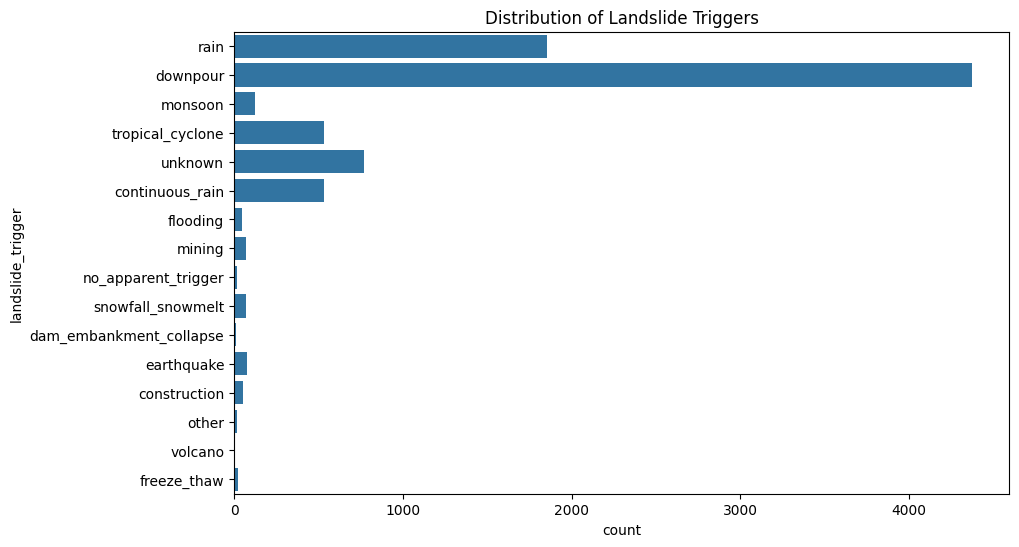

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Descriptive statistics
print(df.describe())

# Correlation matrix
numeric_columns = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_columns].corr()
print(corr_matrix)

# Heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

# Distribution of landslide categories
plt.figure(figsize=(10, 6))
sns.countplot(y='landslide_category', data=df)
plt.title('Distribution of Landslide Categories')
plt.show()

# Distribution of landslide triggers
plt.figure(figsize=(10, 6))
sns.countplot(y='landslide_trigger', data=df)
plt.title('Distribution of Landslide Triggers')
plt.show()


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['landslide_category'], test_size=0.2, random_state=42)

# Define classifiers
svm_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', SVC(kernel='linear', C=1, probability=True))])
rf_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', RandomForestClassifier(n_estimators=100, random_state=42))])
nb_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

# Train classifiers
svm_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
nb_clf.fit(X_train, y_train)

# Predictions
svm_pred = svm_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
nb_pred = nb_clf.predict(X_test)

# Accuracy scores
svm_accuracy = accuracy_score(y_test, svm_pred)
rf_accuracy = accuracy_score(y_test, rf_pred)
nb_accuracy = accuracy_score(y_test, nb_pred)

print(f"SVM Accuracy: {svm_accuracy:.2f}")
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print(f"Naive Bayes Accuracy: {nb_accuracy:.2f}")

# Model evaluation function
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Calculate evaluation metrics for each model
svm_metrics = evaluate_model(y_test, svm_pred)
rf_metrics = evaluate_model(y_test, rf_pred)
nb_metrics = evaluate_model(y_test, nb_pred)

# Create a DataFrame for comparison
metrics_df = pd.DataFrame({
    'Model': ['SVM', 'Random Forest', 'Naive Bayes'],
    'Accuracy': [svm_metrics[0], rf_metrics[0], nb_metrics[0]],
    'Precision': [svm_metrics[1], rf_metrics[1], nb_metrics[1]],
    'Recall': [svm_metrics[2], rf_metrics[2], nb_metrics[2]],
    'F1 Score': [svm_metrics[3], rf_metrics[3], nb_metrics[3]]
})

print(metrics_df)


SVM Accuracy: 0.81
Random Forest Accuracy: 0.79
Naive Bayes Accuracy: 0.67
           Model  Accuracy  Precision    Recall  F1 Score
0            SVM  0.806884   0.778671  0.806884  0.779869
1  Random Forest  0.793466   0.790413  0.793466  0.752829
2    Naive Bayes  0.672695   0.615900  0.672695  0.546316


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best Model: SVM


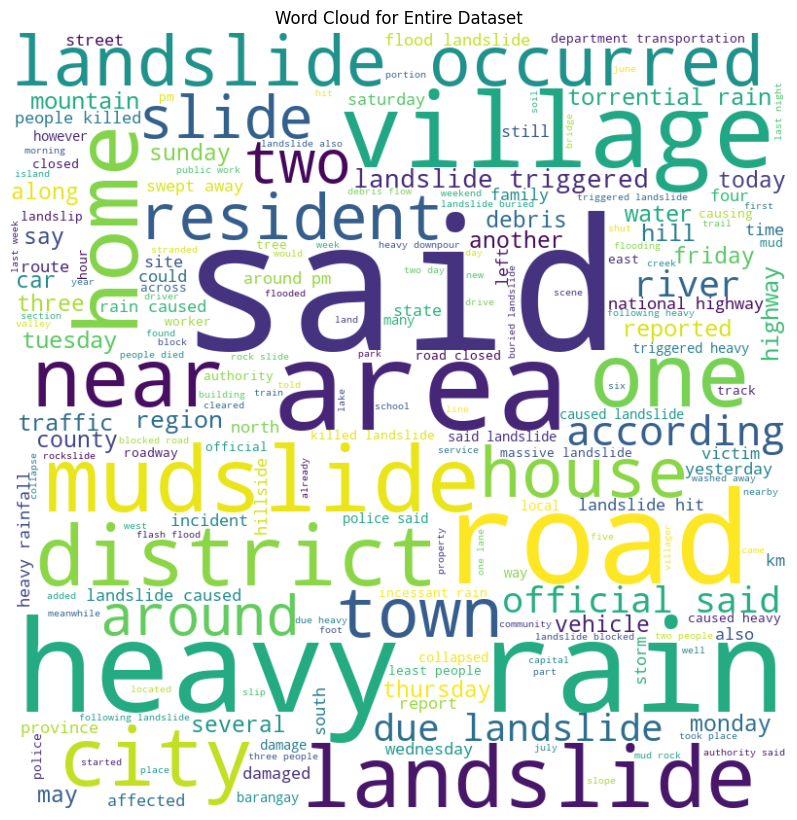

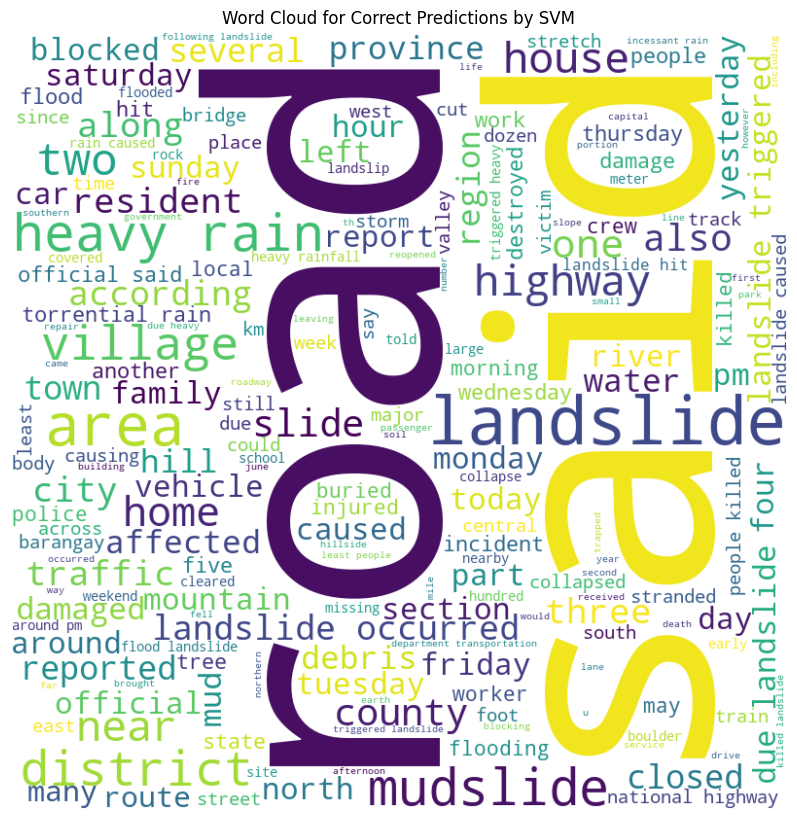

In [6]:
from wordcloud import WordCloud

# Best model selection based on F1 Score
best_model_name = metrics_df.loc[metrics_df['F1 Score'].idxmax(), 'Model']
print(f"Best Model: {best_model_name}")

best_model = None
if best_model_name == 'SVM':
    best_model = svm_clf
elif best_model_name == 'Random Forest':
    best_model = rf_clf
elif best_model_name == 'Naive Bayes':
    best_model = nb_clf

# Create a WordCloud for the entire dataset
def create_wordcloud(text, title='Word Cloud'):
    wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=STOPWORDS).generate(text)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.tight_layout(pad=0)
    plt.show()

# Generate word cloud for the entire dataset
all_text = ' '.join(df['clean_text'])
create_wordcloud(all_text, title='Word Cloud for Entire Dataset')

# Generate word cloud using the best model's predictions
best_pred = best_model.predict(X_test)
correct_predictions = ' '.join(X_test[best_pred == y_test])
create_wordcloud(correct_predictions, title=f'Word Cloud for Correct Predictions by {best_model_name}')


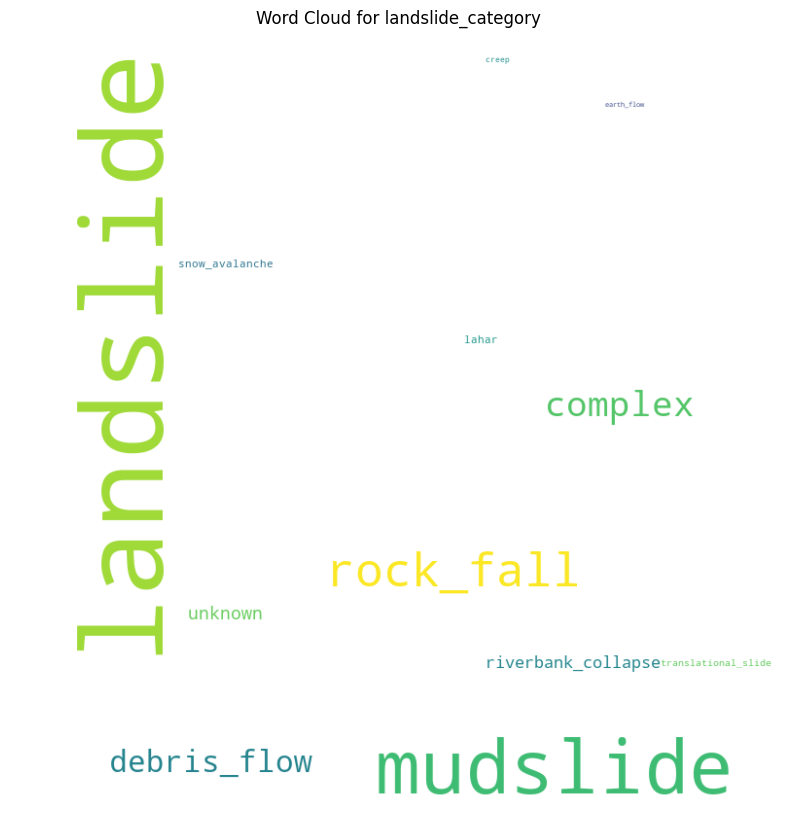

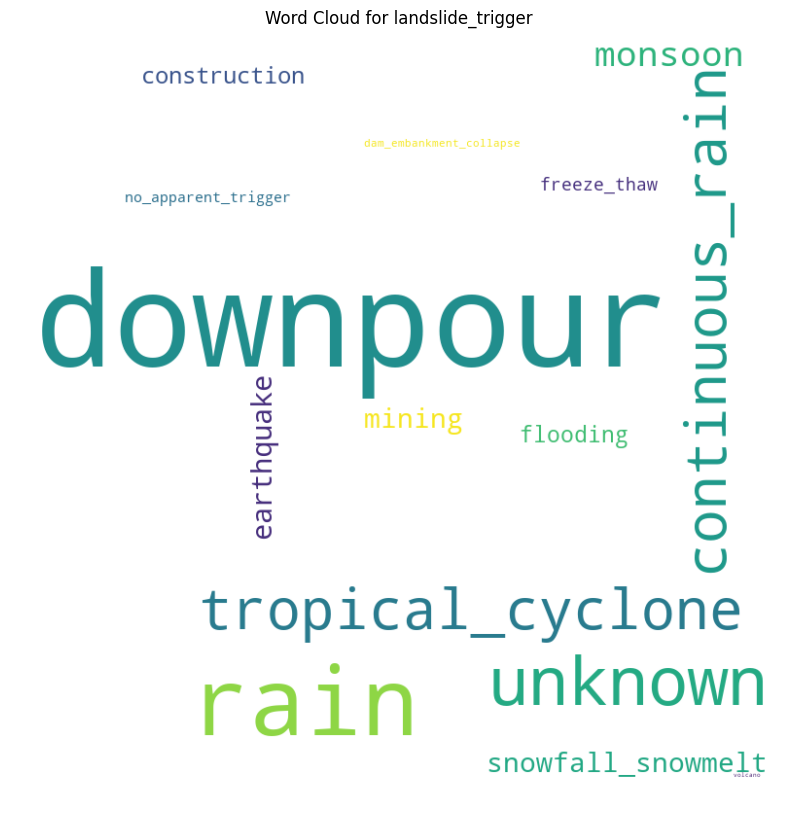

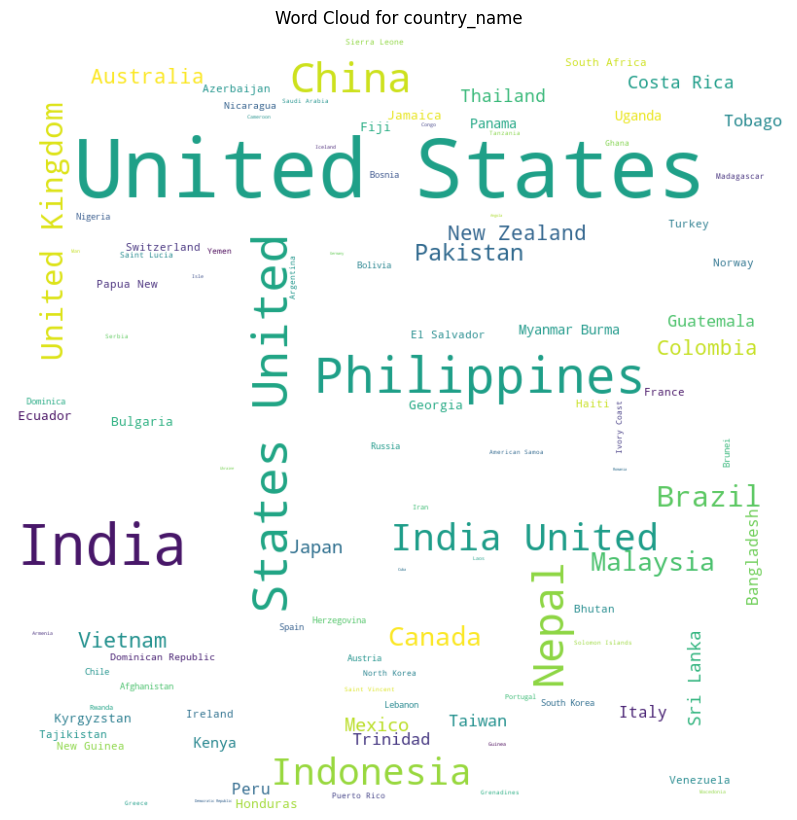

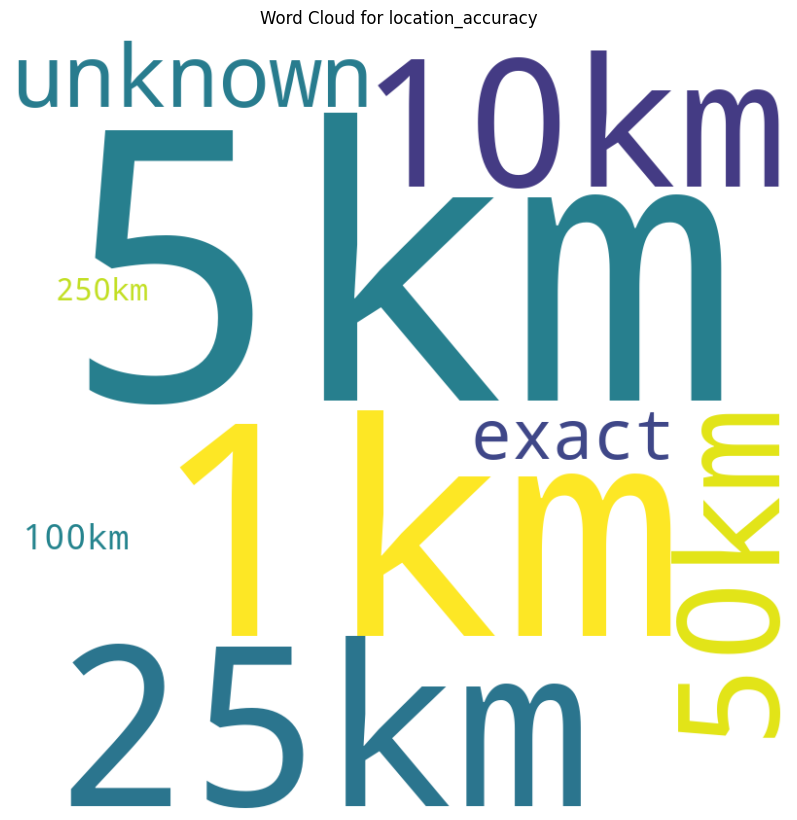

In [7]:
# Generate word clouds for specific columns
columns_to_evaluate = ['landslide_category', 'landslide_trigger', 'country_name', 'location_accuracy']

for col in columns_to_evaluate:
    text = ' '.join(df[col].astype(str).values)
    create_wordcloud(text, title=f'Word Cloud for {col}')


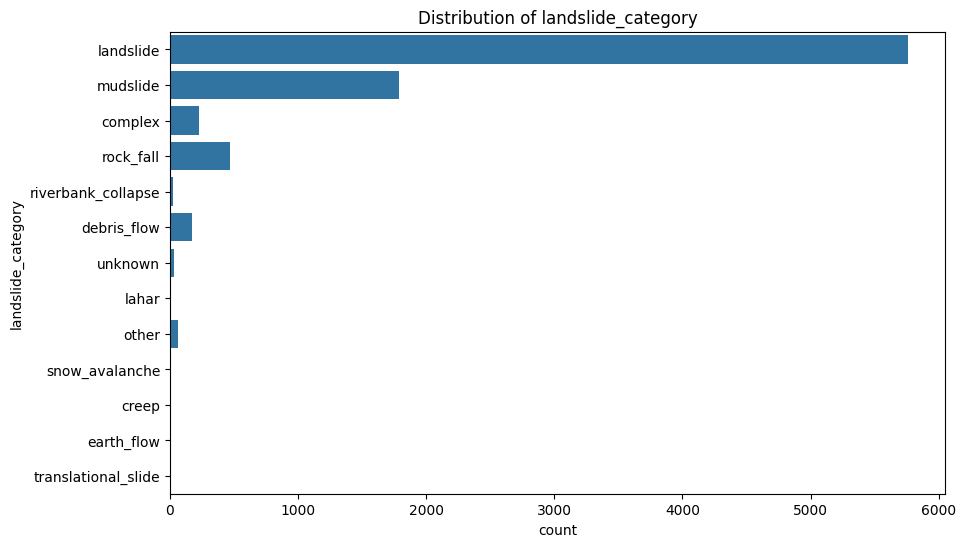

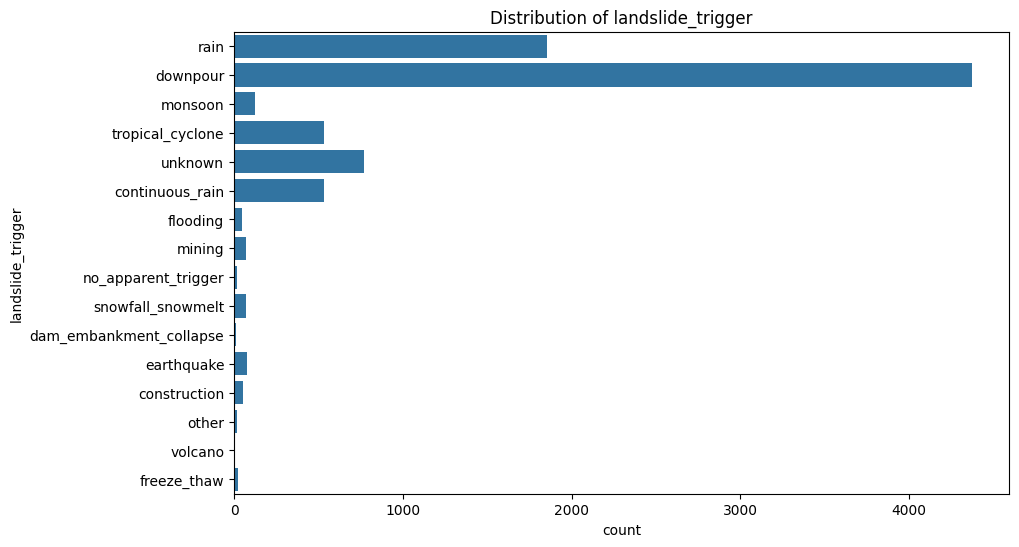

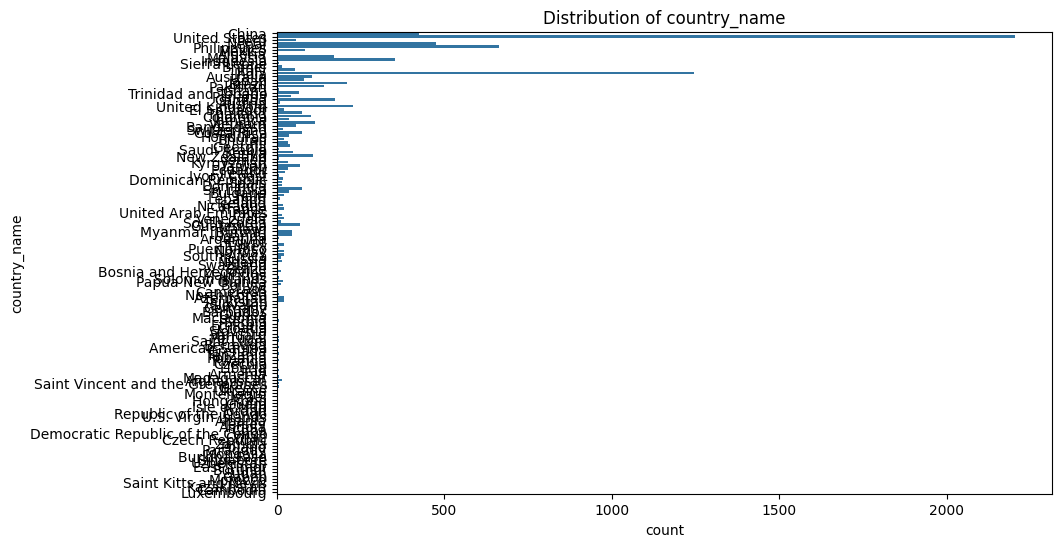

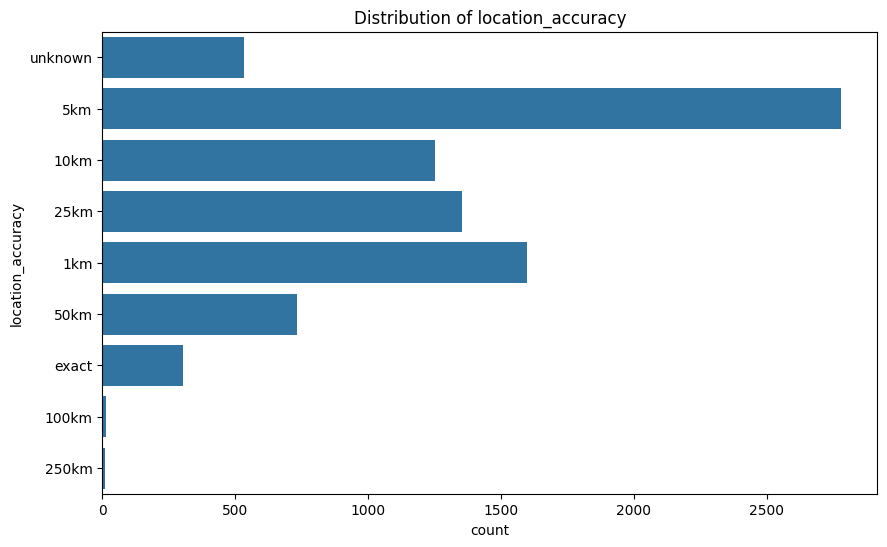

In [8]:
# Further text analysis
for factor in columns_to_evaluate:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=factor, data=df)
    plt.title(f'Distribution of {factor}')
    plt.show()


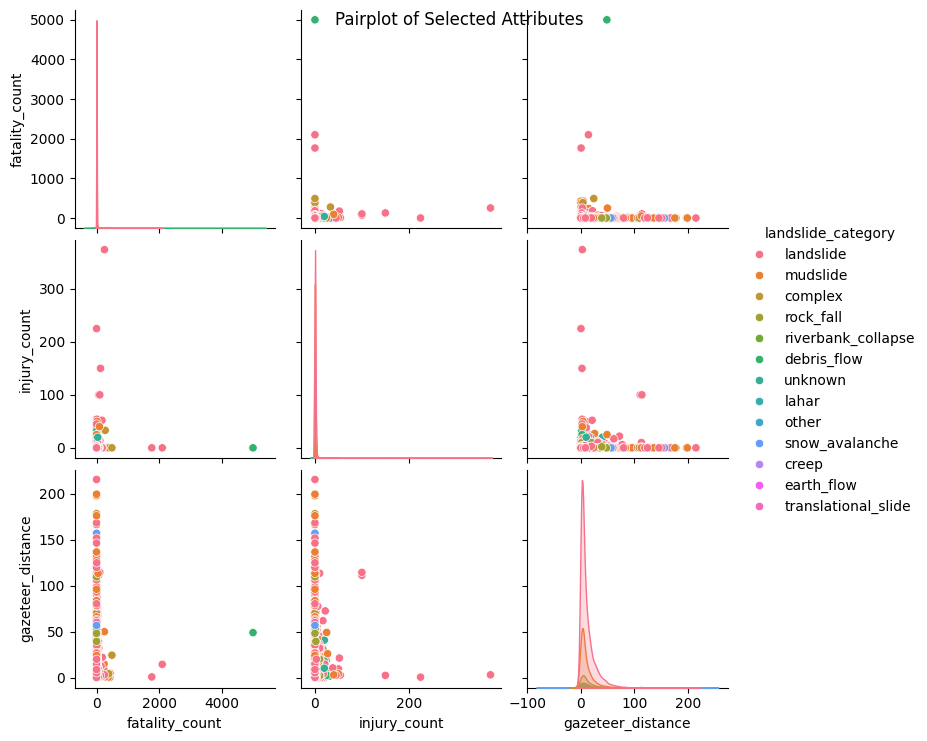

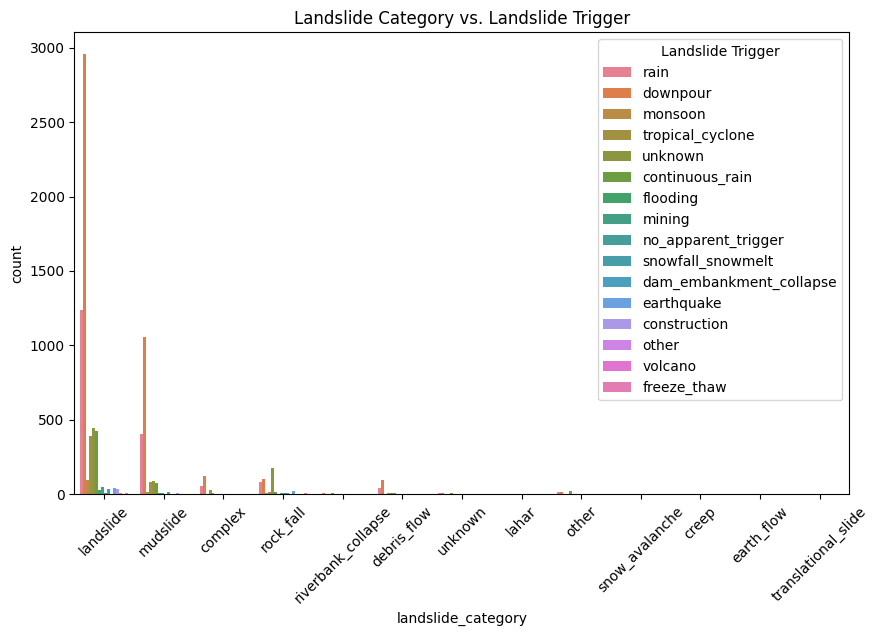

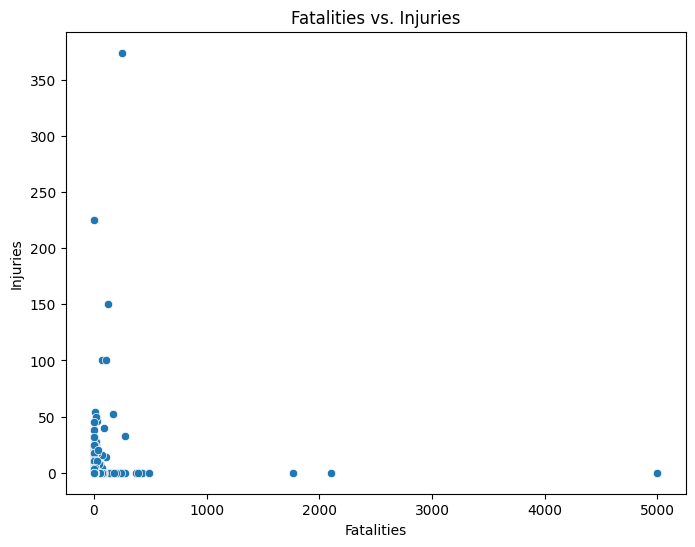

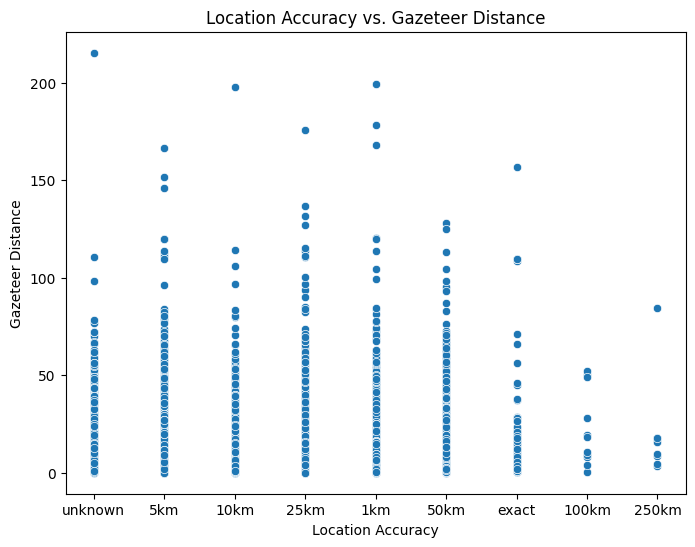

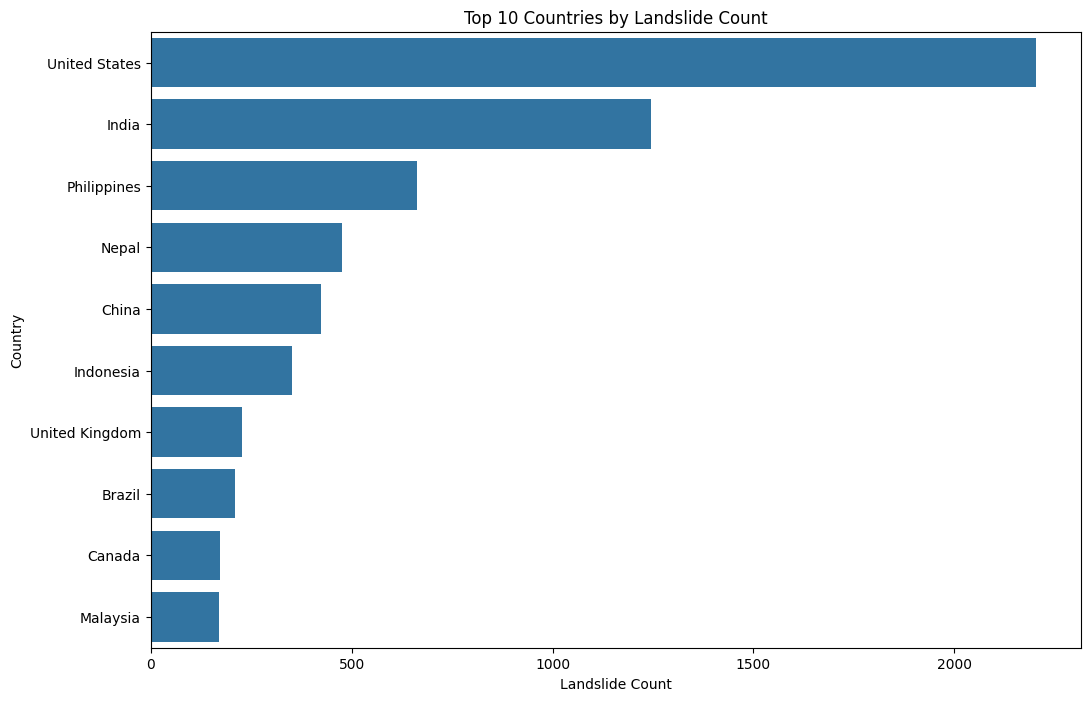

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example of selected attributes
attributes = ['landslide_category', 'landslide_trigger', 'fatality_count', 'injury_count',
              'location_accuracy', 'gazeteer_distance', 'country_name', 'event_id']

# Subset the dataframe with the selected attributes
subset_df = df[attributes]

# Pairplot for correlation exploration
sns.pairplot(subset_df, hue='landslide_category', kind='scatter')
plt.suptitle('Pairplot of Selected Attributes')
plt.show()

# Stacked bar chart for Landslide Category vs. Landslide Trigger
plt.figure(figsize=(10, 6))
sns.countplot(x='landslide_category', hue='landslide_trigger', data=df)
plt.title('Landslide Category vs. Landslide Trigger')
plt.xticks(rotation=45)
plt.legend(title='Landslide Trigger')
plt.show()

# Scatter plot for Fatalities vs. Injuries
plt.figure(figsize=(8, 6))
sns.scatterplot(x='fatality_count', y='injury_count', data=df)
plt.title('Fatalities vs. Injuries')
plt.xlabel('Fatalities')
plt.ylabel('Injuries')
plt.show()

# Scatter plot for Location Accuracy vs. Gazeteer Distance
plt.figure(figsize=(8, 6))
sns.scatterplot(x='location_accuracy', y='gazeteer_distance', data=df)
plt.title('Location Accuracy vs. Gazeteer Distance')
plt.xlabel('Location Accuracy')
plt.ylabel('Gazeteer Distance')
plt.show()

# Choropleth map or bar chart for Country vs. Landslide Count
plt.figure(figsize=(12, 8))
sns.countplot(y='country_name', data=df, order=df['country_name'].value_counts().index[:10])
plt.title('Top 10 Countries by Landslide Count')
plt.xlabel('Landslide Count')
plt.ylabel('Country')
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_21088\784258662.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['year'] = pd.to_datetime(df['event_date']).dt.year


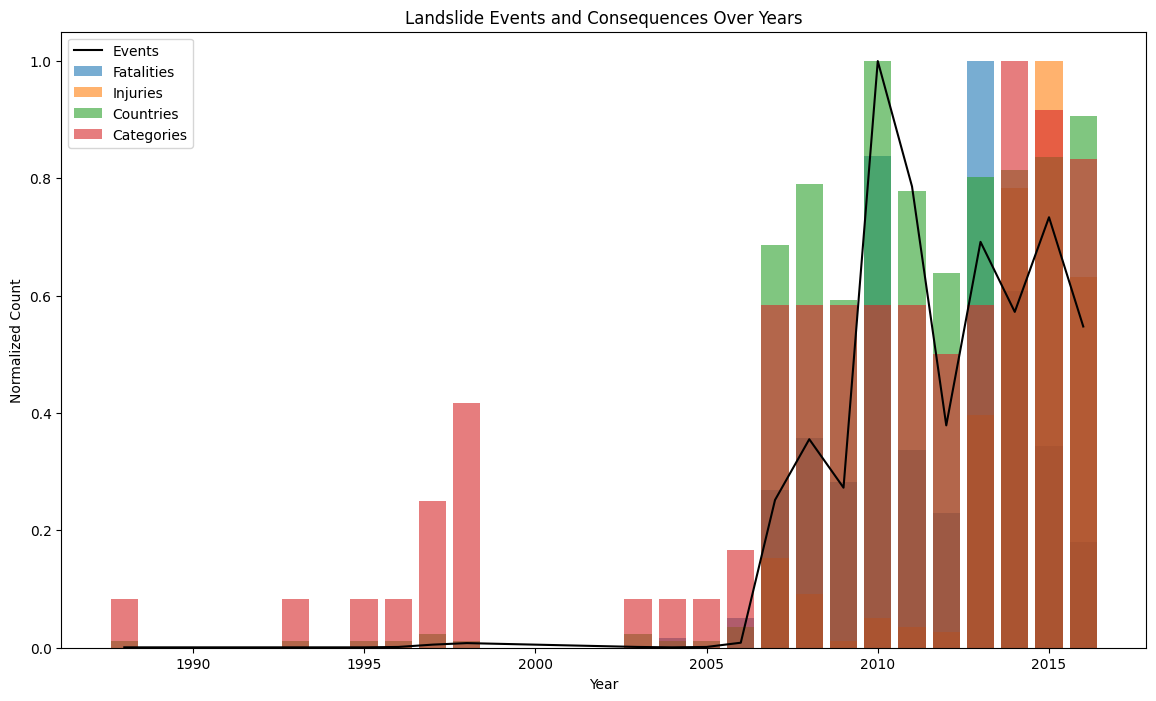

In [10]:
df['year'] = pd.to_datetime(df['event_date']).dt.year
grouped_df = df.groupby('year').agg({
    'event_id': 'count',
    'fatality_count': 'sum',
    'injury_count': 'sum',
    'country_name': pd.Series.nunique,
    'landslide_category': pd.Series.nunique
}).reset_index()

# Normalize the data for better visualization
normalized_df = grouped_df.copy()
for column in ['event_id', 'fatality_count', 'injury_count', 'country_name', 'landslide_category']:
    normalized_df[column] = grouped_df[column] / grouped_df[column].max()

plt.figure(figsize=(14, 8))
plt.plot(normalized_df['year'], normalized_df['event_id'], label='Events', color='black')
plt.bar(normalized_df['year'], normalized_df['fatality_count'], label='Fatalities', alpha=0.6)
plt.bar(normalized_df['year'], normalized_df['injury_count'], label='Injuries', alpha=0.6)
plt.bar(normalized_df['year'], normalized_df['country_name'], label='Countries', alpha=0.6)
plt.bar(normalized_df['year'], normalized_df['landslide_category'], label='Categories', alpha=0.6)

plt.xlabel('Year')
plt.ylabel('Normalized Count')
plt.title('Landslide Events and Consequences Over Years')
plt.legend()
plt.show()
